Using device: cuda
Files already downloaded and verified
Training process for ACGAN:
╒═════════╤══════════════════╤══════════════════════╤═════════════╕
│   Epoch │   Generator Loss │   Discriminator Loss │   FID Score │
╞═════════╪══════════════════╪══════════════════════╪═════════════╡
│       1 │           0.4251 │               0.4033 │     570.507 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       2 │           0.4143 │               0.3807 │     634.342 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       3 │           0.3869 │               0.3268 │     740.698 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       4 │           0.389  │               0.3521 │     696.375 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       5 │           0.4238 │               0.3269 │     556.751 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       6 │           0.3762 │ 

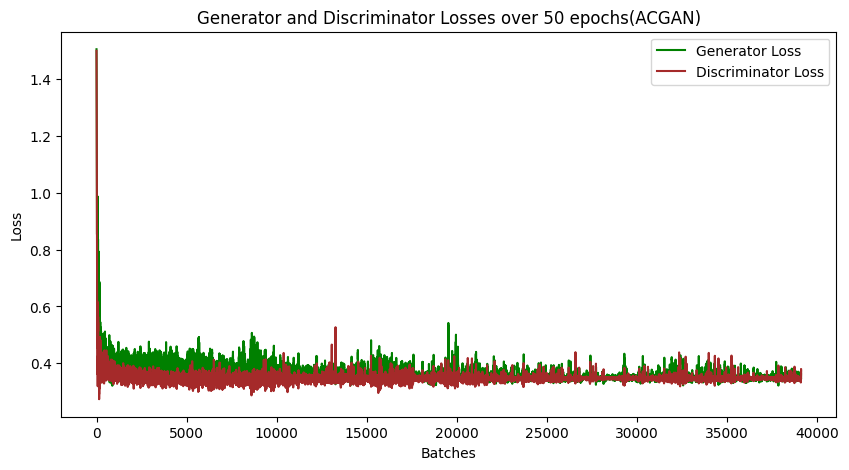

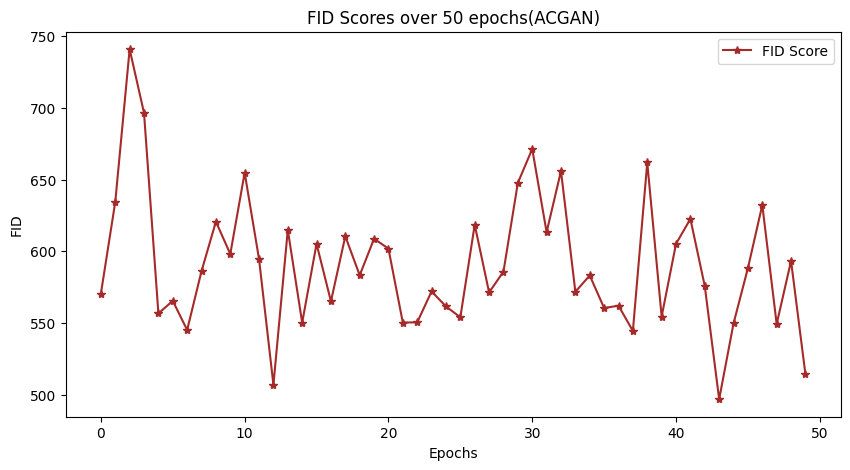

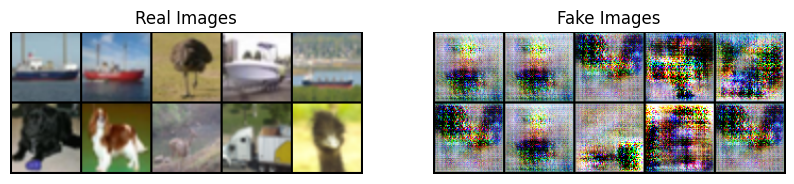

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader,Subset
from torchvision.models import Inception_V3_Weights
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from tabulate import tabulate

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
latent_vector_dim = 100
batch_size = 64
num_channels = 3
learning_rate = 5e-5
beta1 = 0.5
num_epochs = 50
image_size = 64  # CIFAR-10 image size for training

# Dataset preparation
data_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Use the entire CIFAR-10 dataset instead of a subset
cifar10_data = datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=data_transform)
data_loader = DataLoader(cifar10_data, batch_size=batch_size, shuffle=True, num_workers=2)


# Generator network
class ImageGenerator(nn.Module):
    def __init__(self, latent_dim, num_channels):
        super(ImageGenerator, self).__init__()
        self.label_emb = nn.Embedding(10, 100)

        self.model = nn.Sequential(
            nn.Linear(100 + 100, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 4*4*1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(4*4*1024),
            nn.Unflatten(1, (1024, 4, 4)),
            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((label_input, noise), dim=1)
        img = self.model(gen_input)
        return img

# Discriminator network
class ImageDiscriminator(nn.Module):
    def __init__(self, num_channels):
        super(ImageDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(10, 64*64)

        self.model = nn.Sequential(
            nn.Linear(3*64*64 + 64*64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
        )

        self.validity_layer = nn.Linear(128, 1)
        self.aux_label_layer = nn.Linear(128, 10)

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_input = self.label_emb(labels).view(img.size(0), -1)
        d_in = torch.cat((img_flat, label_input), dim=1)
        features = self.model(d_in)

        # Apply Sigmoid to output layers
        validity = torch.sigmoid(self.validity_layer(features))  # Apply sigmoid here
        label = self.aux_label_layer(features)

        return validity, label

# Initialize models
generator = ImageGenerator(latent_vector_dim, num_channels).to(device)
discriminator = ImageDiscriminator(num_channels).to(device)

# Loss and optimizers
criterion_validity = nn.BCELoss()
criterion_aux = nn.CrossEntropyLoss()  # CrossEntropyLoss for auxiliary classifier
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# FID calculation helper
weights = Inception_V3_Weights.IMAGENET1K_V1  # Explicitly specify the weights
inception_model = inception_v3(weights=weights, transform_input=False).to(device)
inception_model.fc = nn.Identity()  # Remove fully connected layer
inception_model.eval()

def calculate_fid(real_images, fake_images):
    real_images = torch.nn.functional.interpolate(real_images, size=(256, 256), mode='bilinear', align_corners=False)
    fake_images = torch.nn.functional.interpolate(fake_images, size=(256, 256), mode='bilinear', align_corners=False)

    real_features = inception_model(real_images).detach().cpu().numpy()
    fake_features = inception_model(fake_images).detach().cpu().numpy()

    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    diff = np.sum((mu_real - mu_fake) ** 2)
    cov_mean = sqrtm(sigma_real @ sigma_fake)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    return diff + np.trace(sigma_real + sigma_fake - 2 * cov_mean)

# Helper function to save resized grids
def save_grids(real_images, fake_images, epoch, output_dir, resize_dims=(256, 256)):
    real_grid = make_grid(real_images[:10], nrow=5, normalize=True)
    fake_grid = make_grid(fake_images[:10], nrow=5, normalize=True)
    save_image(real_grid, os.path.join(output_dir, f"real_grid_epoch_{epoch}.png"))
    save_image(fake_grid, os.path.join(output_dir, f"fake_grid_epoch_{epoch}.png"))

# Training loop
gen_losses, disc_losses, fid_scores = [], [], []
fixed_noise = torch.randn(32, latent_vector_dim, 1, 1, device=device)

outputs_acgan_dir = "./outputs_acgan"
os.makedirs(outputs_acgan_dir, exist_ok=True)


# Initialize a list to store results for tabular display
results = []

print("Training process for ACGAN:")

for epoch in range(num_epochs):
    for batch_idx, (imgs, labels) in enumerate(data_loader):
        batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        z = torch.randn(batch_size, latent_vector_dim, device=device)
        gen_labels = torch.randint(0, 10, (batch_size,), dtype=torch.long, device=device)

        generated_imgs = generator(z, gen_labels)

        optimizerD.zero_grad()

        real_validity, real_aux = discriminator(imgs, labels)
        d_real_loss = (criterion_validity(real_validity, valid) + criterion_aux(real_aux, labels)) / 2

        fake_validity, fake_aux = discriminator(generated_imgs.detach(), gen_labels)
        d_fake_loss = (criterion_validity(fake_validity, fake) + criterion_aux(fake_aux, gen_labels)) / 2

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizerD.step()

        optimizerG.zero_grad()

        validity, aux = discriminator(generated_imgs, gen_labels)
        g_loss = (criterion_validity(validity, valid) + criterion_aux(aux, gen_labels)) / 2
        g_loss.backward()
        optimizerG.step()

        gen_losses.append(g_loss.item())
        disc_losses.append(d_loss.item())

    # Calculate FID score
    with torch.no_grad():
        fid_score = calculate_fid(imgs[:batch_size], generated_imgs[:batch_size])
        fid_scores.append(fid_score)

    # Save grids of 10 real and 10 fake images
    save_grids(imgs, generated_imgs, epoch + 1, outputs_acgan_dir)

    # Append results for the current epoch to the table
    results.append([epoch + 1, f"{gen_losses[-1]:.4f}", f"{disc_losses[-1]:.4f}", f"{fid_score:.4f}"])

# Print the complete table
print(tabulate(results, headers=["Epoch", "Generator Loss", "Discriminator Loss", "FID Score"], tablefmt="fancy_grid"))


# Save the table to a file
table_file_path = os.path.join(outputs_acgan_dir, "training_results.txt")
with open(table_file_path, "w") as file:
    file.write(tabulate(results, headers=["Epoch", "Generator Loss", "Discriminator Loss", "FID Score"], tablefmt="fancy_grid"))

print(f"Training results saved to {table_file_path}")
# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Losses over 50 epochs(ACGAN)")
plt.plot(gen_losses, label="Generator Loss",color="green")
plt.plot(disc_losses, label="Discriminator Loss",color="brown")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(outputs_acgan_dir, "losses.png"))
plt.show()

# Plot FID scores
plt.figure(figsize=(10, 5))
plt.title("FID Scores over 50 epochs(ACGAN)")
plt.plot(fid_scores, label="FID Score", marker='*',color="brown")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig(os.path.join(outputs_acgan_dir, "fid_scores.png"))
plt.show()


# After the training loop and printing the table
# Display the saved grid for the last epoch
last_epoch = num_epochs
real_image_path = os.path.join(outputs_acgan_dir, f"real_grid_epoch_{last_epoch}.png")
fake_image_path = os.path.join(outputs_acgan_dir, f"fake_grid_epoch_{last_epoch}.png")

# Load the saved images using PIL
real_images = Image.open(real_image_path)
fake_images = Image.open(fake_image_path)

# Plot the real and fake images side by side
plt.figure(figsize=(10, 5))

# Plot real images
plt.subplot(1, 2, 1)
plt.imshow(real_images)
plt.title("Real Images")
plt.axis('off')

# Plot fake images
plt.subplot(1, 2, 2)
plt.imshow(fake_images)
plt.title("Fake Images")
plt.axis('off')

plt.show()


In [10]:
# Save the table as a PNG image
def save_table_as_png(results, headers, output_dir, filename="training_results.png"):
    # Create a figure and axis for the table
    fig, ax = plt.subplots(figsize=(8, len(results) * 0.4 + 1))  # Adjust size dynamically
    ax.axis("off")  # Turn off the axis

    # Create the table
    table = ax.table(
        cellText=results,
        colLabels=headers,
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(headers))))  # Adjust column width

    # Save the table as a PNG file
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, bbox_inches="tight")
    plt.close(fig)
    print(f"Training results table saved as PNG at {filepath}")


# Call the function to save the table
save_table_as_png(results, ["Epoch", "Generator Loss", "Discriminator Loss", "FID Score"], outputs_acgan_dir)

Training results table saved as PNG at ./outputs_acgan/training_results.png


In [11]:
!zip -r outputs_acgan.zip outputs_acgan

  adding: outputs_acgan/ (stored 0%)
  adding: outputs_acgan/real_grid_epoch_10.png (deflated 0%)
  adding: outputs_acgan/real_grid_epoch_21.png (deflated 0%)
  adding: outputs_acgan/fake_grid_epoch_50.png (deflated 0%)
  adding: outputs_acgan/fake_grid_epoch_42.png (deflated 0%)
  adding: outputs_acgan/fake_grid_epoch_39.png (deflated 0%)
  adding: outputs_acgan/fake_grid_epoch_5.png (deflated 0%)
  adding: outputs_acgan/real_grid_epoch_6.png (deflated 0%)
  adding: outputs_acgan/real_grid_epoch_1.png (deflated 0%)
  adding: outputs_acgan/real_grid_epoch_16.png (deflated 0%)
  adding: outputs_acgan/real_grid_epoch_25.png (deflated 0%)
  adding: outputs_acgan/real_grid_epoch_24.png (deflated 0%)
  adding: outputs_acgan/fake_grid_epoch_32.png (deflated 0%)
  adding: outputs_acgan/real_grid_epoch_15.png (deflated 0%)
  adding: outputs_acgan/fake_grid_epoch_7.png (deflated 0%)
  adding: outputs_acgan/fake_grid_epoch_19.png (deflated 0%)
  adding: outputs_acgan/fake_grid_epoch_44.png (defl